In [0]:
import pandas as pd
import json
import os
from collections import defaultdict
from pprint import pprint
import re
from itertools import combinations

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
categorical_palette = sns.color_palette(["#88d5d4",
"#f7cb6c",
"#f3a5ac",
"#619c80",
"#df7670",
"#b19fc9"], n_colors=6)
continuous_palette = sns.color_palette("crest")
sns.set(font_scale=1.3, palette=categorical_palette, style='whitegrid')

In [0]:
def strip_gene_name(name):
    return re.sub(r'[^\w\s]', '', name).lower()


In [0]:
uberon_to_tissue_name = json.load(open('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_raw/all_ontology.json', 'r'))

def convert_tissue_name(uberon):
    try:
        return uberon_to_tissue_name['UBERON'][uberon]['label']
    except KeyError:
        print('No name found for %s'%uberon)
        return ''

In [0]:
hubmap_json = json.load(open('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_raw/hubmap_marker_genes.json', 'r'))

# hubmap data formatted like {"tissue": "blood", "symbol": "BCL7A", "name": "BAF chromatin remodeling complex subunit BCL7A", "publication": "10.1073/pnas.172384399", "publication_titles": "Prospective isolation of human clonogenic common myeloid progenitors\n\n - Manz, Markus G. et al. (2002) Proceedings of the National Academy of Sciences"}

def hubmap_to_df(json):

    records = []

    for cell_type, marker_genes in json.items():
        for marker_gene in marker_genes:
            records.append({
                'cl': cell_type,
                'tissue': marker_gene['tissue'].lower(),
                'gene': strip_gene_name(marker_gene['symbol'])
            })
    
    return pd.DataFrame.from_records(records).drop_duplicates()

ground_truth_df = hubmap_to_df(hubmap_json)

Filtered ground truth data looks like:
               cl           tissue   gene
0     CL:0000945            blood  bcl7a
1     CL:0000945            blood   cd19
2     CL:0000945            blood   cd24
3     CL:0000945            blood   cd27
4     CL:0000945            blood   cd40
...          ...              ...    ...
7291  CL:1001319  urinary bladder   pi16
7292  CL:1001319  urinary bladder  pilra
7293  CL:1001319  urinary bladder   slpi
7294  CL:1001319  urinary bladder   stc1
7295  CL:1001319  urinary bladder    tnc

[3631 rows x 3 columns] 


Summary of filtered ground truth data available:


<AxesSubplot:xlabel='Number of marker genes in\nground truth data', ylabel='Number of [tissue, cell type]\ncombinations'>

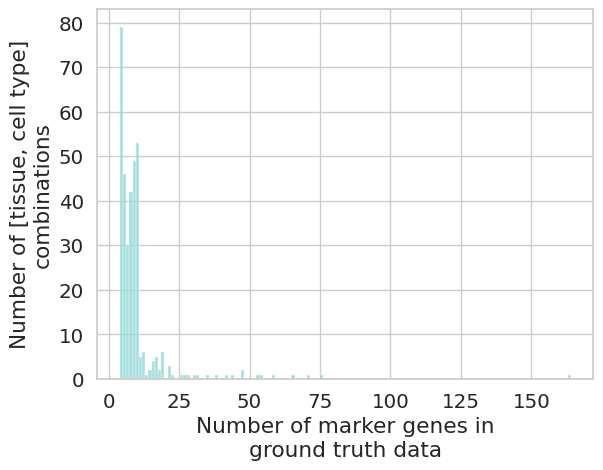

In [0]:
# only look at tissue-specific & cell type-specific marker genes
filtered_ground_truth = ground_truth_df.loc[(ground_truth_df['tissue'] != 'all tissues')]# & (ground_truth_df['tissue'] != 'blood') ]

# only look at groups with at least 4 annotated marker genes
filtered_ground_truth = filtered_ground_truth.groupby(['cl', 'tissue']).filter(lambda group: group.agg('count')['gene'] >= 4)

# inspect results
print('Filtered ground truth data looks like:\n',filtered_ground_truth, '\n\n')
print('Summary of filtered ground truth data available:')
filtered_ground_truth_summary = filtered_ground_truth.groupby(['cl', 'tissue']).agg('count')
fig, ax = plt.subplots()
ax.set_ylabel('Number of [tissue, cell type]\ncombinations')
ax.set_xlabel('Number of marker genes in\nground truth data')
sns.histplot(filtered_ground_truth_summary['gene'], ax=ax)

In [0]:
fp = '/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_raw/ge_marker_genes_rankit.json'
ge_computed = json.load(open(fp, 'r'))

records = []
for cl, marker_genes in ge_computed.items():
    for marker_gene in marker_genes:
        records.append({
            'cl': cl,
            'tissue': convert_tissue_name(marker_gene['tissue_ontology_term_id']),
            'gene': strip_gene_name(marker_gene['symbol']),
            'marker_score': marker_gene['marker_score'],
            })
        
ge_computed_df = pd.DataFrame.from_records(records).drop_duplicates()


Filtered GE-computed data looks like:
                 cl         tissue     gene  marker_score
0       CL:0000034           nose     krt5      1.266993
1       CL:0000034           nose   pcp4l1      0.500498
2       CL:0000034           nose     fat2      0.508665
3       CL:0000034           nose  aldh3a2      0.524203
4       CL:0000034           nose    fgfr3      0.558437
...            ...            ...      ...           ...
335607  CL:1001428  bladder organ     lmo7      0.569866
335608  CL:1001428  bladder organ    ppdpf      0.731366
335609  CL:1001428  bladder organ   marcks      0.619916
335610  CL:1001428  bladder organ  s100a11      0.624020
335611  CL:1001428  bladder organ     h2aj      0.627535

[335336 rows x 4 columns] 


Summary of filtered ground truth data available:


<AxesSubplot:xlabel='Number of marker genes in\nge-computed data', ylabel='Number of [tissue, cell type]\ncombinations'>

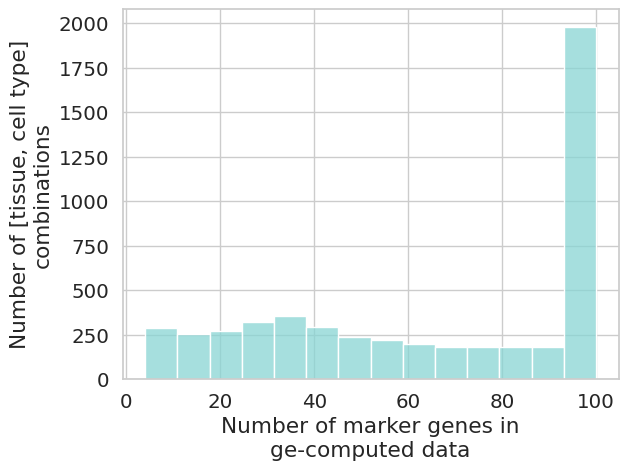

In [0]:
# only look at tissue-specific & cell type-specific marker genes
filtered_ge_computed = ge_computed_df.loc[(ge_computed_df['tissue'] != 'all tissues')]# & (ge_computed_df['tissue'] != 'blood')]

# only look at groups with at least 4 annotated marker genes
filtered_ge_computed = filtered_ge_computed.groupby(['cl', 'tissue']).filter(lambda group: group.agg('count')['gene'] >= 4)

# inspect results
print('Filtered GE-computed data looks like:\n',filtered_ge_computed, '\n\n')
print('Summary of filtered ground truth data available:')
filtered_ge_computed_summary = filtered_ge_computed.groupby(['cl', 'tissue']).agg('count')
fig, ax = plt.subplots()
ax.set_ylabel('Number of [tissue, cell type]\ncombinations')
ax.set_xlabel('Number of marker genes in\nge-computed data')
sns.histplot(filtered_ge_computed_summary['gene'], ax=ax)

In [0]:
ground_truth_tissues = filtered_ground_truth['tissue'].unique()
ground_truth_categories = { tissue: filtered_ground_truth.loc[filtered_ground_truth['tissue'] == tissue]['cl'].unique() for tissue in ground_truth_tissues}

In [0]:
ge_tissues = filtered_ge_computed['tissue'].unique()
overlapping_tissues = set(ge_tissues).intersection(set(ground_truth_tissues))

overlapping_categories = defaultdict(list)

for tissue in overlapping_tissues:
    ge_cell_types_in_tissue = filtered_ge_computed.loc[filtered_ge_computed['tissue'] == tissue]['cl'].unique()

    for cell_type in ge_cell_types_in_tissue:
        if (cell_type) in ground_truth_categories[tissue]:
            overlapping_categories[tissue].append(cell_type)

overlapping_categories = dict(overlapping_categories)
print ('overlapping categories', overlapping_categories)

overlapping categories {'lung': ['CL:0000158', 'CL:4028006', 'CL:0002063', 'CL:0002062', 'CL:0009089', 'CL:1000271', 'CL:4028004'], 'pancreas': ['CL:0008024'], 'placenta': ['CL:0000669', 'CL:0000525', 'CL:0008036'], 'bone marrow': ['CL:0000084', 'CL:0000094', 'CL:0000097', 'CL:0000576', 'CL:0000775', 'CL:0000786', 'CL:0000787', 'CL:0000788', 'CL:0000814', 'CL:0000815', 'CL:0000824', 'CL:0000897', 'CL:0000909', 'CL:0000938', 'CL:0000945', 'CL:0000990', 'CL:0001056', 'CL:0000037', 'CL:0000051', 'CL:0000764', 'CL:0000816', 'CL:0000817', 'CL:0000826', 'CL:0000895', 'CL:0000900', 'CL:0001054', 'CL:0001062', 'CL:0000050', 'CL:0000556', 'CL:0000767', 'CL:0000837', 'CL:0000049', 'CL:0000557', 'CL:0000559', 'CL:0000836', 'CL:0002193', 'CL:0000553', 'CL:0000771'], 'large intestine': ['CL:0000815', 'CL:0009016', 'CL:0019032'], 'blood': ['CL:0000084', 'CL:0000094', 'CL:0000576', 'CL:0000775', 'CL:0000787', 'CL:0000788', 'CL:0000824', 'CL:0000938', 'CL:0000945', 'CL:0001056', 'CL:0002399', 'CL:0000

## Don't test performance on colinear cell types as these are not independent observations

In [0]:
'''
Don't calculate comparisons between a target cell type and other cell types which are direct descendants / ancestors. 
These functions taken directly from prod.
'''

import owlready2

# ontology object
ontology = owlready2.get_ontology('https://github.com/obophenotype/cell-ontology/releases/download/v2023-06-22/cl-basic.owl')
ontology.load()

def descendants(cell_type):
    global ontology
    cell_type_iri = cell_type.replace(":", "_")
    entity = ontology.search_one(iri=f"http://purl.obolibrary.org/obo/{cell_type_iri}")
    descendants = [i.name.replace("_", ":") for i in entity.descendants()] if entity else [cell_type]
    return descendants

def ancestors(cell_type):
    global ontology
    cell_type_iri = cell_type.replace(":", "_")
    entity = ontology.search_one(iri=f"http://purl.obolibrary.org/obo/{cell_type_iri}")
    ancestors = [i.name.replace("_", ":") for i in entity.ancestors()] if entity else [cell_type]
    return ancestors

def are_cell_types_colinear(cell_type1, cell_type2):
    """
    Determine if two cell types are colinear in the ontology.
    Colinearity means that cell type 1 is an aacestor of cell type 2
    or vice-versa.
    Arguments
    ---------
    cell_type1 : str
        Cell type 1 (cell type ontology term id)
    cell_type2 : str
        Cell type 2 (cell type ontology term id)
    Returns
    -------
    bool
    """
    descendants1 = descendants(cell_type1)
    descendants2 = descendants(cell_type2)
    ancestors1 = ancestors(cell_type1)
    ancestors2 = ancestors(cell_type2)
    return len(set(descendants1).intersection(ancestors2)) > 0 or len(set(descendants2).intersection(ancestors1)) > 0

def trim_deepest_colinear_cell_types(cell_types):
    # put the deepest nodes first (i.e., fewest ancestors at the front of the list)
    sorted_cell_types = sorted(cell_types, key=lambda cl: len(ancestors(cl)))

    def check_for_colinear_pairs(sorted_cell_types):
        colinear = []
        for cl1, cl2 in combinations(sorted_cell_types, 2):
            if (are_cell_types_colinear(cl1, cl2)):
                if cl1 not in colinear:
                    colinear.append(cl1)
                if cl2 not in colinear:
                    colinear.append(cl2)
        return set(colinear)

    colinear_cls = check_for_colinear_pairs(sorted_cell_types)
    while len(colinear_cls) > 0:
        sorted_colinear_cls = sorted(list(colinear_cls), key=lambda cl: len(ancestors(cl)))
        sorted_cell_types = [cl for cl in sorted_cell_types if cl != sorted_colinear_cls[0]]
        colinear_cls = check_for_colinear_pairs(sorted_cell_types)

    return sorted_cell_types

In [0]:
for tissue, cls in overlapping_categories.items():
    overlapping_categories[tissue] = trim_deepest_colinear_cell_types(cls)

In [0]:
json.dump(overlapping_categories, open('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_tidy/overlapping_categories.json', 'w'))

## Subset both data frames to the tissues and cell types present in both

In [0]:
overlapping_records_ge_computed = []

for idx, row in filtered_ge_computed.iterrows():
    tissue = row['tissue']
    if tissue in overlapping_categories.keys():
        if row['cl'] in overlapping_categories[tissue]:
            overlapping_records_ge_computed.append(row)

overlapping_ge_computed = pd.DataFrame.from_records(overlapping_records_ge_computed)
print(overlapping_ge_computed.shape, overlapping_ge_computed.head())

(8981, 4)            cl           tissue     gene  marker_score
0  CL:0000034  small intestine  slc12a2      0.503161
1  CL:0000034  small intestine    dmbt1      0.758327
2  CL:0000034  small intestine     mt1g      0.511177
3  CL:0000034  small intestine     pigr      0.519522
4  CL:0000034  small intestine     agr2      0.533159


In [0]:
overlapping_records_ground_truth = []

for idx, row in filtered_ground_truth.iterrows():
    tissue = row['tissue']
    if tissue in overlapping_categories.keys():
        if row['cl'] in overlapping_categories[tissue]:
            overlapping_records_ground_truth.append(row)

overlapping_ground_truth = pd.DataFrame.from_records(overlapping_records_ground_truth)
print(overlapping_ground_truth.shape, overlapping_ground_truth.head())

(1171, 3)            cl       tissue   gene
0  CL:0000816        blood   cd19
1  CL:0000816        blood   ighm
2  CL:0000816        blood  ms4a1
3  CL:0000816        blood   pax5
4  CL:0000816  bone marrow   cd19


In [0]:
overlapping_ge_computed.to_csv('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_tidy/ge_computed_rankit_marker_genes_tidy.csv', index=False)
overlapping_ground_truth.to_csv('/dbfs/FileStore/users/sbell/2023-08_norm_characterization/data_tidy/ground_truth_marker_genes_tidy.csv', index=False)